# 16、stateful lstm的使用
LSTM函数参数中有一个stateful，默认的也是 false，意义是批和批之间是否有联系。直观的理解就是我们在读完二十步，第21步开始是接着前面二十步的。也就是第一个 batch中的最后一步与第二个 batch 中的第一步之间是有联系的。设为True可以搭建更长的长时依赖模型

In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
Using TensorFlow backend.


In [2]:
# since we are using stateful rnn tsteps can be set to 1
tsteps = 1
batch_size = 25
epochs = 10
# number of elements ahead that are used to make the prediction
lahead = 1  # 要预测后面第1个数

In [3]:
def gen_cosine_amp(amp=100, period=1000, x0=0, xn=50000, step=1, k=0.0001):
    """Generates an absolute cosine time series with the amplitude
    exponentially decreasing

    Arguments:
        amp: amplitude of the cosine function
        period: period of the cosine function
        x0: initial x of the time series
        xn: final x of the time series
        step: step of the time series discretization
        k: exponential rate
    """
    cos = np.zeros(((xn - x0) * step, 1, 1))
    for i in range(len(cos)):
        idx = x0 + i * step
        cos[i, 0, 0] = amp * np.cos(2 * np.pi * idx / period)
        cos[i, 0, 0] = cos[i, 0, 0] * np.exp(-k * idx)
    return cos

In [4]:
print('Generating Data...')
cos = gen_cosine_amp()
print('Input shape:', cos.shape)   # 估计是格式问题，故意把格式转为[shape,timestep,input]

Generating Data...
Input shape: (50000, 1, 1)


In [5]:
expected_output = np.zeros((len(cos), 1))
for i in range(len(cos) - lahead):
    expected_output[i, 0] = np.mean(cos[i + 1:i + lahead + 1])

print('Output shape:', expected_output.shape)

Output shape: (50000, 1)


In [6]:
print('Creating Model...')
model = Sequential()
model.add(LSTM(50,
               input_shape=(tsteps, 1),
               batch_size=batch_size,
               implementation=1,
               return_sequences=True,        # 多层lstm这个参数必为真
               stateful=True))
model.add(LSTM(50,
               return_sequences=False,
               stateful=True))
model.add(Dense(1))
model.compile(loss='mse', optimizer='rmsprop')
model.summary()

Creating Model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (25, 1, 50)               10400     
_________________________________________________________________
lstm_2 (LSTM)                (25, 50)                  20200     
_________________________________________________________________
dense_1 (Dense)              (25, 1)                   51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [7]:
%%time
print('Training')
for i in range(epochs):
    print('Epoch', i, '/', epochs)

    # Note that the last state for sample i in a batch will
    # be used as initial state for sample i in the next batch.
    # Thus we are simultaneously training on batch_size series with
    # lower resolution than the original series contained in cos.
    # Each of these series are offset by one step and can be
    # extracted with cos[i::batch_size].

    model.fit(cos, expected_output,
              batch_size=batch_size,
              epochs=1,
              verbose=2,
              shuffle=False)
    model.reset_states()

Training
Epoch 0 / 10
Epoch 1/1
13s - loss: 352.2935
Epoch 1 / 10
Epoch 1/1
12s - loss: 169.9205
Epoch 2 / 10
Epoch 1/1
12s - loss: 116.0261
Epoch 3 / 10
Epoch 1/1
12s - loss: 85.1297
Epoch 4 / 10
Epoch 1/1
12s - loss: 62.6008
Epoch 5 / 10
Epoch 1/1
12s - loss: 44.6787
Epoch 6 / 10
Epoch 1/1
12s - loss: 34.9954
Epoch 7 / 10
Epoch 1/1
12s - loss: 22.4195
Epoch 8 / 10
Epoch 1/1
12s - loss: 19.2742
Epoch 9 / 10
Epoch 1/1
12s - loss: 15.6344
CPU times: user 3min 5s, sys: 11.4 s, total: 3min 17s
Wall time: 2min 5s


Predicting
Plotting Results


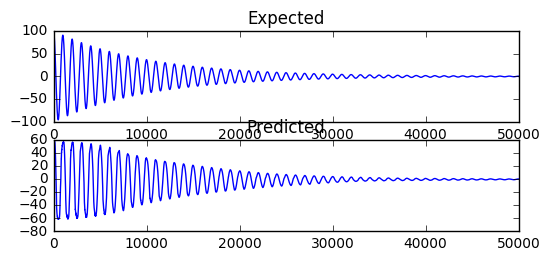

In [8]:
print('Predicting')
predicted_output = model.predict(cos, batch_size=batch_size)

print('Plotting Results')
plt.subplot(3, 1, 1)
plt.plot(expected_output)
plt.title('Expected')
plt.subplot(3, 1, 2)
plt.plot(predicted_output)
plt.title('Predicted')
plt.show()